In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import time
import ColorJitter

plt.ion()   # interactive mode

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
full_train = np.concatenate((X_train, X_test), axis=0)
# full_mean = np.mean(full_train)
# full_std = np.std(full_train)

full_mean = 132.35524/255
full_std = 44.076332/255


In [3]:
class FacesDataset(Dataset):
    """Faces dataset."""

    def __init__(self, X, y, transform=None):
        self.image_vectors = X
        self.targets = y
        self.transform = transform

    def __len__(self):
        return len(self.image_vectors)

    def __getitem__(self, idx):

        one_dim_avg = self.image_vectors[idx]
        one_dim_image = np.reshape(one_dim_avg, (50, 37)).astype('uint8')
        im = Image.fromarray(one_dim_image)
        imrgb = Image.merge('RGB', (im, im, im))

        if self.transform:
            imrgb = self.transform(imrgb)

        return (imrgb, self.targets[idx])


In [18]:
# too: add more transforms later

jitter_data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(224),
        ColorJitter.ColorJitter(contrast=0.15, brightness=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
}
no_data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
}

In [5]:

# %% loading the raw data
X_train_raw = np.load('X_train.npy')
y_train_raw = np.load('y_train.npy')

X_train, X_val, y_train, y_val = train_test_split(X_train_raw,
                                                  y_train_raw,
                                                  random_state=2)

faces_datasets = {
    'train': FacesDataset(X_train, y_train,
                          transform=no_data_transforms['train']),
    'val': FacesDataset(X_val, y_val, transform=no_data_transforms['val'])
}

dataloaders = {x: DataLoader(faces_datasets[x], batch_size=4,
                             shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(faces_datasets[x]) for x in ['train', 'val']}
use_gpu = torch.cuda.is_available()


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_labels = torch.LongTensor()
            running_predictions = torch.LongTensor()

            for data in tqdm(dataloaders[phase]):
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_labels = torch.cat((running_labels, labels.data), 0)
                running_predictions = torch.cat((running_predictions, preds), 0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = f1_score(running_labels.numpy(), running_predictions.numpy(), average='macro')

            print('{} Loss: {:.4f} F1: {:.4f}'.format(
                    phase, epoch_loss, epoch_f1))

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()

        print()
    time_elasped = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elasped // 60, time_elasped % 60))
    print('Best val F1: {:4f}'.format(best_f1))

    model.load_state_dict(best_model_wts)
    return model


In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([full_mean, full_mean, full_mean])
    std = np.array([full_std, full_std, full_std])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [8]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


  0%|          | 0/181 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.2621 F1: 0.5149


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0852 F1: 0.8669

Epoch 1/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0518 F1: 0.9274


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0244 F1: 0.9606

Epoch 2/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0125 F1: 0.9881


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0135 F1: 0.9800

Epoch 3/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0055 F1: 0.9944


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0138 F1: 0.9724

Epoch 4/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0031 F1: 0.9987


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0147 F1: 0.9687

Epoch 5/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0022 F1: 0.9975


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0141 F1: 0.9794

Epoch 6/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0014 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0108 F1: 0.9819

Epoch 7/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0011 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0129 F1: 0.9729

Epoch 8/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0012 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0160 F1: 0.9687

Epoch 9/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0011 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0135 F1: 0.9729

Epoch 10/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0011 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0124 F1: 0.9777

Epoch 11/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0013 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0140 F1: 0.9777

Epoch 12/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0012 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0125 F1: 0.9777

Epoch 13/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0009 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0129 F1: 0.9729

Epoch 14/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0009 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0137 F1: 0.9732

Epoch 15/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0009 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0139 F1: 0.9777

Epoch 16/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0017 F1: 0.9984


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0132 F1: 0.9707

Epoch 17/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0009 F1: 0.9992


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0112 F1: 0.9863

Epoch 18/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0009 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0149 F1: 0.9754

Epoch 19/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0008 F1: 1.0000


100%|██████████| 61/61 [00:26<00:00,  2.34it/s]

val Loss: 0.0115 F1: 0.9777

Training complete in 83m 7s
Best val F1: 0.986282


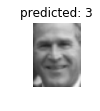

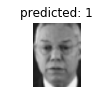

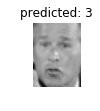

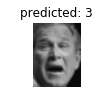

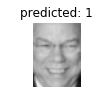

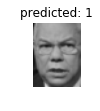

In [9]:
# no flip

model_ft = models.resnet18(pretrained=True)
# swap out the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

criterion = nn.CrossEntropyLoss()

# todo: Try adam
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 20

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)

visualize_model(model_ft)
plt.ioff()
plt.show()

In [10]:
# save model parameters only
torch.save(model_ft.state_dict(), 'resnet18_no_{}epochs.pt'.format(num_epochs))

# save entire model
torch.save(model_ft, 'resnet18_no_{}epochs.model'.format(num_epochs))

In [21]:
# %% loading the raw data
X_train_raw = np.load('X_train.npy')
y_train_raw = np.load('y_train.npy')

X_train, X_val, y_train, y_val = train_test_split(X_train_raw,
                                                  y_train_raw,
                                                  random_state=2)

faces_datasets = {
    'train': FacesDataset(X_train, y_train,
                          transform=jitter_data_transforms['train']),
    'val': FacesDataset(X_val, y_val, transform=jitter_data_transforms['val'])
}

dataloaders = {x: DataLoader(faces_datasets[x], batch_size=4,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(faces_datasets[x]) for x in ['train', 'val']}
use_gpu = torch.cuda.is_available()

  0%|          | 0/181 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.2789 F1: 0.4647


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.1061 F1: 0.7840

Epoch 1/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0766 F1: 0.8912


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0340 F1: 0.9396

Epoch 2/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0236 F1: 0.9750


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0161 F1: 0.9678

Epoch 3/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0074 F1: 0.9954


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0083 F1: 0.9913

Epoch 4/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0045 F1: 0.9947


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0084 F1: 0.9913

Epoch 5/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0048 F1: 0.9952


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0090 F1: 0.9865

Epoch 6/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0017 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0086 F1: 0.9913

Epoch 7/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0015 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0113 F1: 0.9774

Epoch 8/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0012 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0100 F1: 0.9913

Epoch 9/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0013 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0098 F1: 0.9913

Epoch 10/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0013 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0100 F1: 0.9868

Epoch 11/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0012 F1: 0.9992


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0079 F1: 0.9913

Epoch 12/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0011 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0094 F1: 0.9913

Epoch 13/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0015 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0086 F1: 0.9865

Epoch 14/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0012 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0092 F1: 0.9913

Epoch 15/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0009 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0084 F1: 0.9913

Epoch 16/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0011 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0077 F1: 0.9865

Epoch 17/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0017 F1: 0.9980


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0096 F1: 0.9868

Epoch 18/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0011 F1: 1.0000


  0%|          | 0/181 [00:00<?, ?it/s]

val Loss: 0.0092 F1: 0.9822

Epoch 19/19
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0014 F1: 1.0000


100%|██████████| 61/61 [00:28<00:00,  2.14it/s]

val Loss: 0.0093 F1: 0.9913

Training complete in 93m 34s
Best val F1: 0.991310


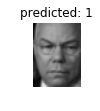

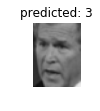

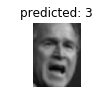

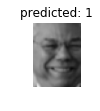

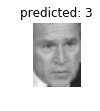

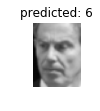

In [22]:
# jitter

model_ft = models.resnet18(pretrained=True)
# swap out the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

criterion = nn.CrossEntropyLoss()

# todo: Try adam
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 20

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)

visualize_model(model_ft)
plt.ioff()
plt.show()

In [23]:
# save model parameters only
torch.save(model_ft.state_dict(), 'resnet18_jitter_{}epochs.pt'.format(num_epochs))

# save entire model
torch.save(model_ft, 'resnet18_jitter_{}epochs.model'.format(num_epochs))

In [24]:
# write code to run on test data
X_test_raw = np.load('X_test.npy')

test_dataset = FacesDataset(X_test_raw, np.zeros(X_test_raw.shape),
                            transform=jitter_data_transforms['val'])

test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=4)

model = torch.load('resnet18_jitter_20epochs.model')
model.eval()

results = np.array([])

for i, data in enumerate(tqdm(test_dataloader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        results = np.append(results, preds.numpy())

# save output predictions of test data
with open('output_alotofjitter.csv', 'w') as f:
    f.write('ImageId,PredictedClass\n')
    for i in range(len(X_test_raw)):
        f.write('{},{}\n'.format(i, int(results[i])))

100%|██████████| 81/81 [00:45<00:00,  1.77it/s]


In [ ]:
# write code to train on train + val

In [ ]:
# write code to train on test again